<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/language-models/transformers_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import tensorflow as tf
from tensorflow import matmul, cast, float32,sqrt, math, transpose
from tensorflow import convert_to_tensor, string
from keras.backend import softmax
from numpy import random
from tensorflow.keras.layers import TextVectorization, Embedding, Layer, Dropout
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt


In [34]:
class DotProductAttention(Layer):
  def __init__(self, **kwargs):
    super(DotProductAttention, self).__init__(**kwargs)

  def call(self, queries, keys, values, d_k, mask=None):
    scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))
    if mask is not None:
      scores += (mask * -1e9)
    weights = softmax(scores)
    attention_weights = matmul(weights, values)
    return attention_weights

In [35]:
# Testing the DotProductAttention

d_k = 64
d_v = 64
batch_size = 64
input_seq_len = 10

queries = random.random((batch_size, input_seq_len, d_k))
keys = random.random((batch_size, input_seq_len, d_k))
values = random.random((batch_size, input_seq_len, d_v))

attention = DotProductAttention()
attention_weights = attention(queries, keys, values, d_k)
print(queries.shape)


(64, 10, 64)


In [36]:
class MultiHeadAttention(Layer):
  def __init__(self, n_heads, d_k, d_v, d_model, **kwargs):
    super(MultiHeadAttention, self).__init__(**kwargs)
    self.n_heads = n_heads
    self.attention = DotProductAttention()
    self.d_k = d_k
    self.d_v = d_v
    self.W_q = tf.keras.layers.Dense(d_k)
    self.W_k = tf.keras.layers.Dense(d_k)
    self.W_v = tf.keras.layers.Dense(d_v)
    self.W_o = tf.keras.layers.Dense(d_model)

  def reshape_tensor(self, x, heads, flag):
    if flag:
      x = tf.reshape(x, shape = (x.shape[0], x.shape[1], heads, -1))
      x = transpose(x, perm=[0, 2, 1, 3])
    else:
      x = transpose(x, perm=(0, 2, 1, 3))
      x = tf.reshape(x, shape=(x.shape[0], x.shape[1], -1))
    return x

  def call(self, queries, keys, values, mask=None):
    # this converts the queries to shape (batch_size, heads, input_length, -1)
    q_reshaped = self.reshape_tensor(self.W_q(queries), self.n_heads, True)
    # this converts the keys to shape (batch_size, heads, input_length, -1)
    k_reshaped = self.reshape_tensor(self.W_k(keys), self.n_heads, True)
    # this converts the values to shape (batch_size, heads, input_length, -1)
    v_reshaped = self.reshape_tensor(self.W_v(values), self.n_heads, True)
    # compute attention weights in parallel, reshapes to (batch_size, heads, input_length, -1)
    o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
    o = self.reshape_tensor(o_reshaped, self.n_heads, False)
    o = self.W_o(o)
    return o


In [37]:
# Testing the above code
n_heads = 8
d_k = 64
d_v = 64
d_model = 512 # embedding size
batch_size = 64
input_seq_len = 10

# 4, 64, 64, 512
multihead_attention = MultiHeadAttention(n_heads, d_k, d_v, d_model)
# 64, 10, 64
queries = random.random((batch_size, input_seq_len, d_k))
keys = random.random((batch_size, input_seq_len, d_k))
values = random.random((batch_size, input_seq_len, d_v))

print(queries.shape)
attention_weights = multihead_attention(queries, keys, values)
print(attention_weights.shape)

(64, 10, 64)
(64, 10, 512)


In [38]:
# Positional embedding matrix

def pos_enc_matrix(L, d, n=1000):
  assert d % 2 == 0
  d2 = d // 2
  P = np.zeros((L, d))
  # creates a 1d array of evenly spaced values and converting it into column vector
  k = np.arange(L).reshape(-1, 1)
  i = np.arange(d2).reshape(1,-1)
  denom = np.power(n, -i/d2) # n ** (-2*i/d)
  args = k * denom
  P[:, ::2] = np.sin(args)
  P[:, 1::2] = np.cos(args)
  return P

pos_matrix = pos_enc_matrix(4, 4)
assert pos_matrix.shape == (4,4)
print(pos_matrix.shape)
print(pos_matrix)


(4, 4)
[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.03161751  0.99950004]
 [ 0.90929743 -0.41614684  0.0632034   0.99800067]
 [ 0.14112001 -0.9899925   0.09472609  0.99550337]]


In [63]:
# Positional Embedding

class PositionalEmbeddingLayer(Layer):
  def __init__(self, max_seq_len, vocab_size, output_dim, **kwargs):
    super(PositionalEmbeddingLayer, self).__init__(**kwargs)
    self.word_embedding_layer = Embedding(vocab_size, output_dim, mask_zero=True)
    self.max_seq_len = max_seq_len
    self.output_dim = output_dim
    self.vocab_size = vocab_size

  def compute_mask(self, *args, **kwargs):
      return self.word_embedding_layer.compute_mask(*args, **kwargs)

  def call(self, inputs):
    embedded_words = self.word_embedding_layer(inputs)
    embedded_positions = pos_enc_matrix(self.max_seq_len, self.output_dim)
    return embedded_words + tf.constant(embedded_positions, dtype = "float32")

In [64]:
my_embedding_layer = PositionalEmbeddingLayer(9, 1000, 512)
print(my_embedding_layer(tf.constant([[1, 2, 3, 4, 5, 6, 7, 8, 9]])).shape)

(1, 9, 512)


In [41]:
class FeedForward(Layer):
  def __init__(self, d_model, d_ff, **kwargs):
    super(FeedForward, self).__init__(**kwargs)
    self.d_fc1 = tf.keras.layers.Dense(d_ff)
    self.d_fc2 = tf.keras.layers.Dense(d_model)
    self.activation = tf.keras.layers.ReLU()

  def call(self, x):
    x = self.d_fc1(x)
    x = self.d_fc2(self.activation(x))
    return x

In [42]:
class Normalization(Layer):
  def __init__(self, **kwargs):
    super(Normalization, self).__init__(**kwargs)
    self.layer_Norm = tf.keras.layers.LayerNormalization()

  def call(self, x, sublayer_x):
    return self.layer_Norm(x + sublayer_x)

In [43]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

class EncoderLayer(Layer):
  def __init__(self, sequence_length, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
    super(EncoderLayer, self).__init__(**kwargs)
    self.build(input_shape=[None, sequence_length, d_model])
    self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
    self.dropout1 = Dropout(rate)
    self.norm1 = Normalization()
    self.feed_forward = FeedForward(d_model, d_ff)
    self.dropout2 = Dropout(rate)
    self.norm2 = Normalization()
    self.d_model = d_model
    self.sequence_length = sequence_length

  def build_graph(self):
    input_layer = Input(shape=(self.sequence_length, self.d_model))
    print(input_layer.shape)
    return Model(inputs = [input_layer], outputs = self.call(input_layer, None, True))

  def call(self, x, padding_mask, training):
    # expected output length - batch_size, sequence_length, d_model
    print(x, x, x, padding_mask)
    multihead_output = self.multihead_attention(x, x, x, padding_mask)
    multihead_output = self.dropout1(multihead_output, training=training)
    add_norm_output = self.norm1(x, multihead_output)
    feed_forward_output = self.feed_forward(add_norm_output)
    feed_forward_output = self.dropout2(feed_forward_output, training=training)
    return self.norm2(add_norm_output, feed_forward_output)

In [44]:
class Encoder(Layer):
  def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
    super(Encoder, self).__init__(**kwargs)
    self.pos_encoding = PositionalEmbeddingLayer(sequence_length, vocab_size, d_model)
    self.dropout = Dropout(rate)
    self.encoder_layers = [EncoderLayer(sequence_length, h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

  def call(self, inputs, padding_mask, training):
    x = self.pos_encoding(inputs)
    x = self.dropout(x, training=training)
    for encoder_layer in self.encoder_layers:
      x = encoder_layer(x, padding_mask, training)
    return x

In [45]:
# Testing the above code
n_heads = 8
d_k = 64
d_v = 64
d_model = 512 # embedding size
batch_size = 64
input_seq_len = 10

# encoder = EncoderLayer(input_seq_len, n_heads, d_k, d_v, d_model, 2048, 0.1)
# encoder.build_graph().summary()

# encoder = Encoder(1000, 10, n_heads, d_k, d_v, d_model, 2048, 6, 0.1)
# print(encoder(tf.random.uniform((batch_size, input_seq_len)), None, training=False).shape)
# 64, 10, 512

In [46]:
class DecoderLayer(Layer):
  def __init__(self, sequence_length, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
    super(DecoderLayer, self).__init__(**kwargs)
    self.build(input_shape=[None, sequence_length, d_model])
    self.multihead_attention1 = MultiHeadAttention(h, d_k, d_v, d_model)
    self.dropout1 = Dropout(rate)
    self.norm1 = Normalization()
    self.multihead_attention2 = MultiHeadAttention(h, d_k, d_v, d_model)
    self.dropout2 = Dropout(rate)
    self.norm2 = Normalization()
    self.feed_forward = FeedForward(d_model, d_ff)
    self.dropout3 = Dropout(rate)
    self.norm3 = Normalization()
    self.d_model = d_model
    self.sequence_length = sequence_length

  def build_graph(self):
    input_layer = Input(shape=[self.sequence_length, self.d_model])
    return Model(inputs = [input_layer], outputs = self.call(input_layer, None, True))

  def call(self, x, encoder_output, padding_mask, look_ahead_mask, training):
    # expected output length - batch_size, sequence_length, d_model
    multihead_output1 = self.multihead_attention1(x, x, x, look_ahead_mask)
    multihead_output1 = self.dropout1(multihead_output1, training=training)
    add_norm_output1 = self.norm1(x, multihead_output1)
    multihead_output2 = self.multihead_attention2(add_norm_output1, encoder_output, encoder_output, padding_mask)
    multihead_output2 = self.dropout2(multihead_output2, training=training)
    norm_output2 = self.norm2(add_norm_output1, multihead_output2)
    feed_forward_output = self.feed_forward(norm_output2)
    feed_forward_output = self.dropout3(feed_forward_output, training=training)
    return self.norm3(norm_output2, feed_forward_output)

In [47]:
class Decoder(Layer):
  def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
    super(Decoder, self).__init__(**kwargs)
    self.pos_encoding = PositionalEmbeddingLayer(sequence_length, vocab_size, d_model)
    self.dropout = Dropout(rate)
    self.decoder_layers = [DecoderLayer(sequence_length, h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

  def call(self, inputs, encoder_output, padding_mask, look_ahead_mask, training):
    x = self.pos_encoding(inputs)
    x = self.dropout(x, training=training)
    for decoder_layer in self.decoder_layers:
      x = decoder_layer(x, encoder_output, padding_mask, look_ahead_mask, training)
    return x

In [48]:
# Testing the above code
n_heads = 4
d_k = 64
d_v = 64
d_model = 512 # embedding size
batch_size = 64
input_seq_len = 10

decoder = Decoder(1000, 10, n_heads, d_k, d_v, d_model, 2048, 6, 0.1)
print(decoder(tf.random.uniform((batch_size, input_seq_len)),  tf.random.uniform((batch_size, input_seq_len, d_model)), None, True).shape)
# 64, 10, 512

(64, 10, 512)


In [49]:
from tensorflow import math, cast, float32
from numpy import array

def padding_mask(input):
  # returns tensor with True for positions with value as 0
  mask = math.equal(input, 0)
  # converts false/true to numbers
  mask = cast(mask, float32)
  return mask

padding_mask(array([1, 2, 3, 0, 0, 0]))

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 1., 1., 1.], dtype=float32)>

In [50]:
from tensorflow import linalg, ones

def look_ahead_mask(shape):
  # mask out future entries by replace with 1.0
  mask = 1- linalg.band_part(ones((shape, shape)), -1, 0)
  return mask

# the ones values mask out the values that the decoder must not see
# the prediction of every word should depend on word before that only
print(look_ahead_mask(5))

tf.Tensor(
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)


In [51]:
from tensorflow.keras import Model
from tensorflow import maximum, newaxis

class TransformerModel(Model):
  def __init__(self, enc_seq_vocab_size, dec_seq_vocab_size, enc_seq_len, dec_seq_len, h, d_k, d_v, d_model, d_ff_inner, n, rate, **kwargs):
    super(TransformerModel, self).__init__(**kwargs)
    self.encoder = Encoder(enc_seq_vocab_size, enc_seq_len, h, d_k, d_v, d_model, d_ff_inner, n, rate)
    self.decoder = Decoder(dec_seq_vocab_size, dec_seq_len, h, d_k, d_v, d_model, d_ff_inner, n, rate)
    self.model_last_layer = tf.keras.layers.Dense(d_model)

  def padding_mask(input):
    # returns tensor with True for positions with value as 0
    mask = math.equal(input, 0)
    # converts false/true to numbers
    mask = cast(mask, float32)
    return mask[:, newaxis, newaxis, :]

  def look_ahead_mask(shape):
    # mask out future entries by replace with 1.0
    mask = 1- linalg.band_part(ones((shape, shape)), -1, 0)
    return mask

  def call(self, encoder_input, decoder_input, training):
    enc_padding_mask = self.padding_mask(encoder_input)

    dec_padding_mask = self.padding_mask(decoder_input)
    dec_look_ahead_mask = self.look_ahead_mask(decoder_input.shape[1])
    dec_look_ahead_mask = maximum(dec_padding_mask, dec_look_ahead_mask)

    encoder_output = self.encoder(encoder_input, enc_padding_mask, training)
    decoder_output = self.decoder(decoder_input, encoder_output, dec_look_ahead_mask, dec_padding_mask, training)
    model_output = self.model_last_layer(decoder_output)
    return model_output


In [52]:
enc_vocab_size = 20 # Vocabulary size for the encoder
dec_vocab_size = 20 # Vocabulary size for the decoder

enc_seq_length = 5  # Maximum length of the input sequence
dec_seq_length = 5  # Maximum length of the target sequence

h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack

dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers

# Create model
training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
# encoder = EncoderLayer(enc_seq_length, h, d_k, d_v, d_model, d_ff, dropout_rate)
# encoder.build_graph().summary()

# decoder = DecoderLayer(dec_seq_length, h, d_k, d_v, d_model, d_ff, dropout_rate)
# decoder.build_graph().summary()

## Preparing the data

In [53]:
import pathlib
import pickle
import random
import re
import unicodedata

import tensorflow as tf

# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)

text_file = pathlib.Path(text_file).parent / "fra.txt"

def normalize(line):
    """Normalize a line of text and split into two at the tab character"""
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    return eng, fra

# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

# print some samples
for _ in range(5):
    print(random.choice(text_pairs))

with open("text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)

3423204/3423204 [==============================] - 0s 0us/step
("you can't be too careful when you drive a car .", '[start] tu ne pourras jamais être trop prudent lorsque tu conduis une voiture . [end]')
("i'll never forget this experience .", "[start] je n'oublierai jamais cette expérience . [end]")
("tom is still at his grandfather's house .", '[start] tom est toujours chez son grand-père . [end]')
("let's try this .", '[start] essayons ça . [end]')
('are there any books under the desk ?', '[start] y a-t-il quelque livre sous le bureau  ?  [end]')


In [54]:
# find out how many distinct tokens exist

import pickle

with open("text_pairs.pickle", "rb") as fp:
    text_paris = pickle.load(fp)

eng_tokens, fra_tokens = set(), set()
eng_maxlength, fra_maxlength = 0, 0
for eng, fra in text_paris:
    eng_token, fra_token = eng.split(), fra.split()
    eng_maxlength = max(len(eng_token), eng_maxlength)
    fra_maxlength = max(len(fra_token), fra_maxlength)
    eng_tokens.update(eng_token)
    fra_tokens.update(fra_token)
print(f"Total English tokens = {len(eng_tokens)}")
print(f"Total French tokens = {len(fra_tokens)}")
print(f"Maximum English sequence length = {eng_maxlength}")
print(f"Maximum French sequence length = {fra_maxlength}")

Total English tokens = 14969
Total French tokens = 29219
Maximum English sequence length = 51
Maximum French sequence length = 60


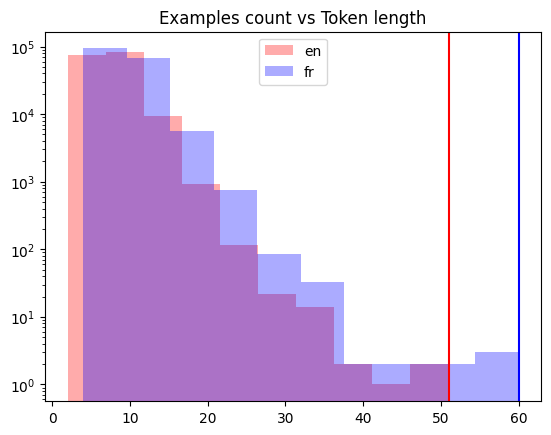

In [55]:
import pickle

import matplotlib.pyplot as plt

with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

In [56]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization
from tensorflow import convert_to_tensor, int64
from pickle import load
from numpy.random import shuffle

class PrepareDataset:
  def __init__(self, **kwargs):
    super(PrepareDataset, self).__init__(**kwargs)
    self.n_sentences = 1000
    self.train_split = 0.9
    self.vocab_size_eng = 10000
    self.vocab_size_fra = 20000
    self.max_seq_length = 20

  def find_vocab_size(self, tokenizer, dataset):
    tokenizer.fit_on_texts(dataset)
    return len(tokenizer.word_index) + 1

  def format_dataset(self, eng, fra):
    print(eng, fra)
    eng = self.eng_vectorizer(eng)
    fra = self.fra_vectorizer(fra)
    source = { 'encoder_inputs': eng, 'decoder_inputs': fra[:, :-1]}
    target = fra[:, 1:]
    return source, target

  def __call__(self, filename, **kwargs):

    clean_data = pickle.load(open(filename, 'rb'))
    dataset = clean_data[:self.n_sentences]
    shuffle(dataset)
    train_pairs = dataset[:int(self.train_split * self.n_sentences)]
    test_pairs = dataset[int(self.train_split * self.n_sentences):]

    eng_vectorizer = TextVectorization(
        max_tokens = self.vocab_size_eng,
        standardize = None,
        split = "whitespace",
        output_mode = "int",
        output_sequence_length = self.max_seq_length
    )

    fra_vectorizer = TextVectorization(
        max_tokens = self.vocab_size_fra,
        standardize = None,
        split = "whitespace",
        output_mode = "int",
        output_sequence_length = self.max_seq_length
    )

    train_eng_texts = [pairs[0] for pairs in train_pairs]
    train_fra_texts = [pairs[1] for pairs in train_pairs]

    eng_vectorizer.adapt(train_eng_texts)
    fra_vectorizer.adapt(train_fra_texts)

    self.eng_vectorizer = eng_vectorizer
    self.fra_vectorizer = fra_vectorizer
    self.train = train_pairs
    self.test = test_pairs

    with open("vectorizer.pickle", "wb") as fp:
        data = {
            "train" : train_pairs,
            "test" : test_pairs,
            "eng_vectorizer_weights" : eng_vectorizer.get_weights(),
            "fra_vectorizer_weights" : fra_vectorizer.get_weights(),
            "eng_vectorizer_config" : eng_vectorizer.get_config(),
            "fra_vectorizer_vocab" : fra_vectorizer.get_config()
        }
        pickle.dump(data, fp)

    eng_texts_train, fra_texts_train = zip(*train_pairs)
    eng_texts_test, fra_texts_test = zip(*test_pairs)

    train_ds = tf.data.Dataset.from_tensor_slices((list(eng_texts_train), list(fra_texts_train))).shuffle(2048).batch(batch_size).map(self.format_dataset).prefetch(16).cache()
    test_ds = tf.data.Dataset.from_tensor_slices((list(eng_texts_test), list(fra_texts_test))).shuffle(2048).batch(batch_size).map(self.format_dataset).prefetch(16).cache()

    return train_ds, test_ds

In [66]:
dataset = PrepareDataset()
train_ds, test_ds = dataset( "text_pairs.pickle")
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    embed_en = PositionalEmbeddingLayer(20, 10000, 512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask.shape)



Tensor("args_0:0", shape=(None,), dtype=string) Tensor("args_1:0", shape=(None,), dtype=string)
Tensor("args_0:0", shape=(None,), dtype=string) Tensor("args_1:0", shape=(None,), dtype=string)
inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [ 3 24 19  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(64, 20, 512)
(64, 20)
